In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import gp_minimize

In [120]:
logins_df = pd.read_json('logins.json')
logins_df.set_index('login_time', inplace=True)
logins_df.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [121]:
logins_df["login count (15 minute interval)"] = 1
np.sort(np.array((logins_df.index[0:18])))

array(['1970-01-01T20:12:16.000000000', '1970-01-01T20:13:18.000000000',
       '1970-01-01T20:16:10.000000000', '1970-01-01T20:16:36.000000000',
       '1970-01-01T20:16:37.000000000', '1970-01-01T20:21:41.000000000',
       '1970-01-01T20:26:05.000000000', '1970-01-01T20:26:21.000000000',
       '1970-01-01T20:31:03.000000000', '1970-01-01T20:34:46.000000000',
       '1970-01-01T20:34:58.000000000', '1970-01-01T20:35:38.000000000',
       '1970-01-01T20:35:47.000000000', '1970-01-01T20:36:34.000000000',
       '1970-01-01T20:39:25.000000000', '1970-01-01T20:40:37.000000000',
       '1970-01-01T20:43:59.000000000', '1970-01-01T20:47:52.000000000'],
      dtype='datetime64[ns]')

In [122]:
logins_df=pd.DataFrame(logins_df.resample('15Min')["login count (15 minute interval)"].sum())
logins_df.head()

,login count (15 minute interval)
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


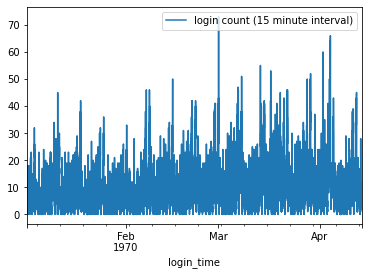

In [123]:
logins_df.plot()
plt.show()

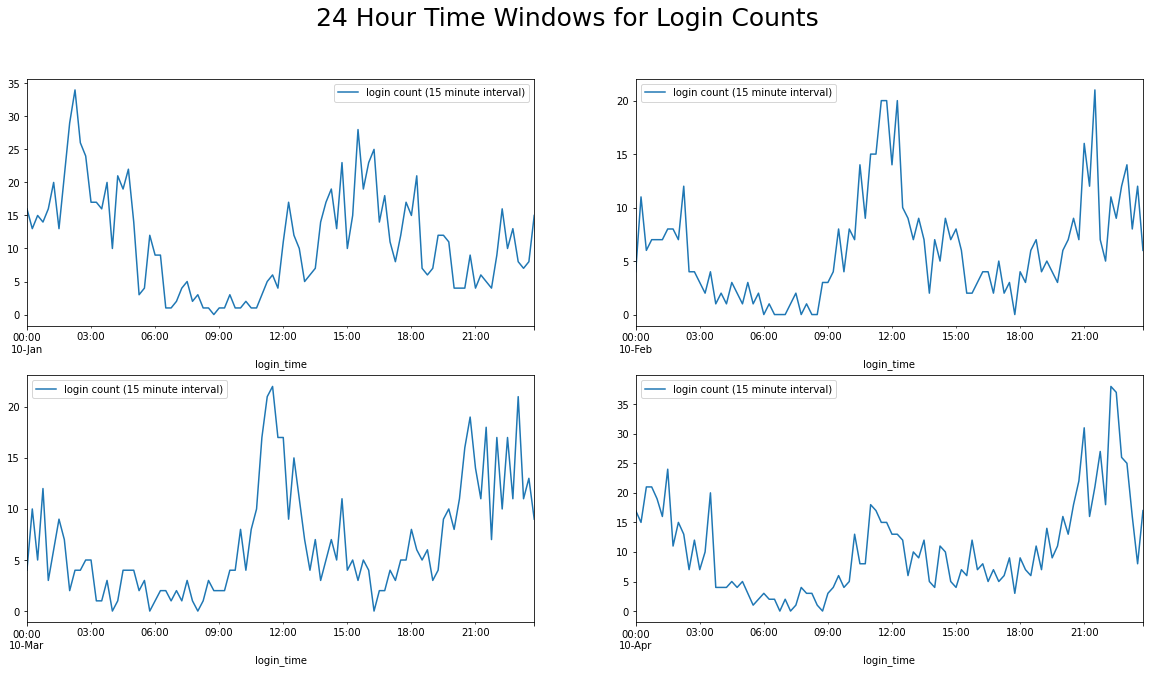

In [124]:
fig, panes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
fig.suptitle('24 Hour Time Windows for Login Counts', fontsize=25)
logins_df.loc['1970-01-10'].plot(ax=panes[0,0])
logins_df.loc['1970-02-10'].plot(ax=panes[0,1])
logins_df.loc['1970-03-10'].plot(ax=panes[1,0])
logins_df.loc['1970-04-10'].plot(ax=panes[1,1])
print()

The daily pattern of this time series shows two major peaks, one in the day time and the other late at night.

### Toll Problem Recommendation:

Reimburse tolls for a one-month trial period.

For Gotham:

Take the existing set of timestamps of trips during one calendar month and resample them 10,000 times.  Determine how many times the number of day trips
within these random samples exceeds the number of day trips after the company started reimbursing tolls.  Divide by 10,000 to get the p-value.  If the p-value
is at or below 0.05: success.  If greater: failure.

For Metropolis:

Do the same except replace 'day trips' with 'night trips'.

The only caveat is that the existing calculations of revenue per trip have to be modified to include the toll.  Prior expectations of such revenue have to
be downgraded accordingly.  If these expectations as downgraded are not met, then the reimbursement should stop.

### Predictive Modeling:


<br>

In [125]:
challenge_df = pd.read_json('ultimate_data_challenge.json')
challenge_df.head().style.hide_index()

city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
King's Landing,4,2014-01-25,4.700000,1.100000,2014-06-17,iPhone,15.400000,True,46.200000,3.670000,5.000000
Astapor,0,2014-01-29,5.000000,1.000000,2014-05-05,Android,0.000000,False,50.000000,8.260000,5.000000
Astapor,3,2014-01-06,4.300000,1.000000,2014-01-07,iPhone,0.000000,False,100.000000,0.770000,5.000000
King's Landing,9,2014-01-10,4.600000,1.140000,2014-06-29,iPhone,20.000000,True,80.000000,2.360000,4.900000
Winterfell,14,2014-01-27,4.400000,1.190000,2014-03-15,Android,11.800000,False,82.400000,3.130000,4.900000


In [126]:
challenge_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [127]:
challenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [128]:
challenge_df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

One hot code the 'city' column:

In [129]:
dummies = pd.get_dummies(challenge_df['city'])
challenge_df[dummies.columns] = dummies
challenge_df.drop('city', axis=1, inplace=True)
challenge_df.head().style.hide_index()

trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell
4,2014-01-25,4.700000,1.100000,2014-06-17,iPhone,15.400000,True,46.200000,3.670000,5.000000,0,1,0
0,2014-01-29,5.000000,1.000000,2014-05-05,Android,0.000000,False,50.000000,8.260000,5.000000,1,0,0
3,2014-01-06,4.300000,1.000000,2014-01-07,iPhone,0.000000,False,100.000000,0.770000,5.000000,1,0,0
9,2014-01-10,4.600000,1.140000,2014-06-29,iPhone,20.000000,True,80.000000,2.360000,4.900000,0,1,0
14,2014-01-27,4.400000,1.190000,2014-03-15,Android,11.800000,False,82.400000,3.130000,4.900000,0,0,1


Take an overview if 'trips_in_first_30_days':

In [130]:
challenge_df['trips_in_first_30_days'].value_counts()[:10]

0    15390
1    14108
2     7402
3     3788
4     2562
5     1616
6     1134
7      819
8      589
9      471
Name: trips_in_first_30_days, dtype: int64

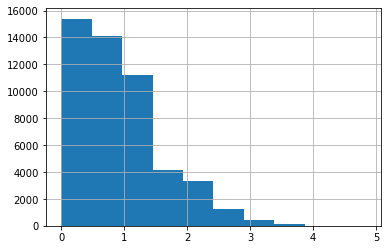

In [131]:
np.log((challenge_df['trips_in_first_30_days'] + 1)).hist()
plt.show()

Make the date of sign-up a datetime series:

In [132]:
challenge_df['signup_date'] = pd.to_datetime(challenge_df['signup_date'])
challenge_df['signup_date'].head()

0   2014-01-25
1   2014-01-29
2   2014-01-06
3   2014-01-10
4   2014-01-27
Name: signup_date, dtype: datetime64[ns]

Examining the ratings of drivers:

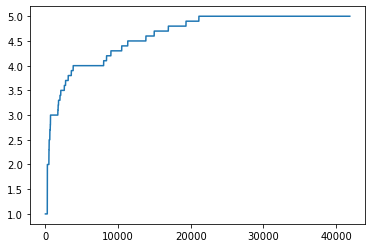

In [133]:
pd.Series(np.sort(np.array(challenge_df['avg_rating_of_driver']))).plot()
plt.show()

In [134]:
challenge_df[['avg_rating_of_driver']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_rating_of_driver  41878 non-null  float64
dtypes: float64(1)
memory usage: 390.8 KB


And imputing the mean thereof:

In [135]:
challenge_df['avg_rating_of_driver'].fillna(value=challenge_df['avg_rating_of_driver'].mean(), inplace=True)

Looking at the average surge:

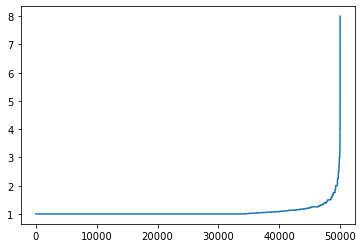

In [136]:
pd.Series(np.sort(np.array(challenge_df['avg_surge']))).plot()
plt.show()

As shown in a prior cell, there are no missing values.  Also, the curve of sorted vales is plausible.  Now, turning to the last trip date:

In [137]:
challenge_df['last_trip_date'] = pd.to_datetime(challenge_df['last_trip_date'])
challenge_df['last_trip_date'].head()

0   2014-06-17
1   2014-05-05
2   2014-01-07
3   2014-06-29
4   2014-03-15
Name: last_trip_date, dtype: datetime64[ns]

In [138]:
challenge_df[['last_trip_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   last_trip_date  50000 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 390.8 KB


Now to subtract 30 days from the most recent timestamp in this column.  Customers who used the service on or after this date are considered to be active.

In [139]:
retention_date = challenge_df['last_trip_date'].max() - pd.Timedelta(days = 30)
retention_date

Timestamp('2014-06-01 00:00:00')

In [140]:
challenge_df['active rider'] = (challenge_df['last_trip_date'] >= retention_date).astype(int)
challenge_df['active rider'].value_counts()

0    31196
1    18804
Name: active rider, dtype: int64

The tendency towards inactivity (more '0' than '1') is intuitive for a dataset that is being analyzed because of inactivity.  Of particular interest is the fraction of observed users who were retained:

In [141]:
challenge_df['active rider'].value_counts()[1]/challenge_df.shape[0]

0.37608

Looking at the phone type, in the cases where none is given,  the type will be 'unknown'.

In [142]:
challenge_df['phone'].fillna('unknown', inplace=True)

In [143]:
challenge_df['phone'].value_counts()

iPhone     34582
Android    15022
unknown      396
Name: phone, dtype: int64

Under one hot coding, phones will be tabulated as either 'iPhone' or 'Android'.  The unknown's will simply lack a positive value in either of these two fields.

In [144]:
dummies = pd.get_dummies(challenge_df['phone'])
challenge_df[dummies.columns] = dummies
challenge_df.drop(['phone', 'unknown'], axis=1, inplace=True)
challenge_df.head().style.hide_index()

trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,active rider,Android,iPhone
4,2014-01-25 00:00:00,4.700000,1.100000,2014-06-17 00:00:00,15.400000,True,46.200000,3.670000,5.000000,0,1,0,1,0,1
0,2014-01-29 00:00:00,5.000000,1.000000,2014-05-05 00:00:00,0.000000,False,50.000000,8.260000,5.000000,1,0,0,0,1,0
3,2014-01-06 00:00:00,4.300000,1.000000,2014-01-07 00:00:00,0.000000,False,100.000000,0.770000,5.000000,1,0,0,0,0,1
9,2014-01-10 00:00:00,4.600000,1.140000,2014-06-29 00:00:00,20.000000,True,80.000000,2.360000,4.900000,0,1,0,1,0,1
14,2014-01-27 00:00:00,4.400000,1.190000,2014-03-15 00:00:00,11.800000,False,82.400000,3.130000,4.900000,0,0,1,0,1,0


Conserning 'surge_pct':

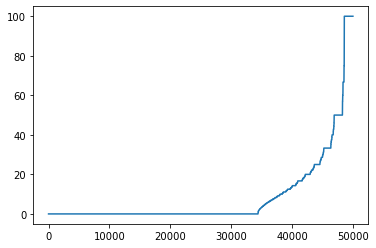

In [145]:
pd.Series(np.sort(np.array(challenge_df['surge_pct']))).plot()
plt.show()

Nothing to report here.  Concerning 'ultimate_black_user', the only modification will be to turn the column into an interger.

In [146]:
challenge_df['ultimate_black_user'] = challenge_df['ultimate_black_user'].astype(int)
challenge_df['ultimate_black_user'].value_counts()

0    31146
1    18854
Name: ultimate_black_user, dtype: int64

The rest of the columms were already cleared in the cell in which the '.describe' method was used on the main dataframe except that the missing values in 'avg_rating_by_driver' have to be imputed.

In [147]:
challenge_df['avg_rating_by_driver'].fillna(value=challenge_df['avg_rating_by_driver'].mean(), inplace=True)
challenge_df[['avg_rating_by_driver']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_rating_by_driver  50000 non-null  float64
dtypes: float64(1)
memory usage: 390.8 KB


How long has the customer been signed up?

In [148]:
 challenge_df['service duration'] = challenge_df['last_trip_date'].max() - challenge_df['signup_date']

In [149]:
challenge_df['service duration'] = [challenge_df['service duration'][i].days for i in \
                                    range (len(challenge_df['service duration']))]

In [150]:
challenge_df['service duration'].min(), challenge_df['service duration'].max()

(151, 181)

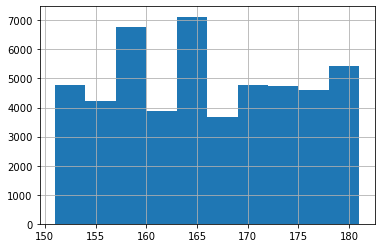

In [151]:
challenge_df['service duration'].hist()
plt.show()

Because everybody has been signed up for a timeframe of between 151 and 181 days, this problem is to be interpreted as a labeling problem to account for who is and who is not an active customer according to there having been usage or non-usage in the last 30 days.

In [152]:
challenge_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,active rider,Android,iPhone,service duration
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,0,1,0,1,0,1,157
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,1,0,0,0,1,0,153
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,1,0,0,0,0,1,176
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,0,1,0,1,0,1,172
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,1,0,1,0,155


In [153]:
def input_validator_class(X, y):
    global y_test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    scaler_object = StandardScaler()
    scaler_object.fit(X_train)
    X_train = scaler_object.transform(X_train)
    X_test = scaler_object.transform(X_test)
    
    def objective(params):
        global y_pred, probs
        learning_rate = params[0]
        max_features = params[1]
        min_samples_split = params[2]
        n_iter_no_change = params[3]
        min_samples_leaf = params[4]
        max_depth = params[5]
    
        model = GradientBoostingClassifier\
        (\
         random_state=44, 
         learning_rate = params[0],\
         max_features = params[1],\
         min_samples_split = params[2],\
         n_iter_no_change = params[3],\
         min_samples_leaf = params[4],\
         max_depth = params[5]\
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        probs = model.predict_proba(X_test)
        return -metrics.accuracy_score(y_test, y_pred)
    space = [\
        [i for i in range(10,120,10)],                     #learning_rate                
        ["auto", "sqrt", "log2"],                          #max_features
        [2,4,8],                                           #min_samples_split
        [0,1,2,3,4,5],                                     #n_iter_no_change
        [1, 2, 4],                                         #min_samples_leaf
        [i for i in range(10,120,10)]                      #max_depth
        ]
    
    return gp_minimize(objective, space, n_calls=50, random_state=0)

In [154]:
gb = input_validator_class(challenge_df.drop(['active rider', 'signup_date', 'last_trip_date'], axis=1), \
                           challenge_df['active rider'])
-gb.fun

0.7542424242424243

We will try to improve on this with a different classifier:

In [165]:
def input_validator_forest(X, y):
    global y_test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    scaler_object = StandardScaler()
    scaler_object.fit(X_train)
    X_train = scaler_object.transform(X_train)
    X_test = scaler_object.transform(X_test)
    
    def objective(params):
        global y_pred, probs
        n_estimators = params[0]
        max_features = params[1]
        min_samples_split = params[2]
        bootstrap = params[3]
        min_samples_leaf = params[4]
        max_depth = params[5]
    
        model = RandomForestClassifier\
        (\
         n_jobs=-1, random_state=0, n_estimators = n_estimators,\
         max_features = params[1],\
         min_samples_split = params[2],\
         bootstrap = params[3],\
         min_samples_leaf = params[4],\
         max_depth = params[5]\
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        probs = model.predict_proba(X_test)
        return -metrics.accuracy_score(y_test, y_pred)
    space = [\
        [i for i in range(10,120,10)],                     #n_estimators                
        ["auto", "sqrt", "log2"],                          #max_features
        [2,4,8],                                           #min_samples_split
        [True, False],                                     #bootstrap
        [1, 2, 4],                                         #min_samples_leaf
        [i for i in range(10,120,10)]                      #max_depth
        ]
    
    return gp_minimize(objective, space, n_calls=50, random_state=0)

In [166]:
rF = input_validator_forest(challenge_df.drop(['active rider', 'signup_date', 'last_trip_date'], axis=1), \
                           challenge_df['active rider'])
-rF.fun

0.7861212121212121

The vlues for  n_estimators, max_features, min_samples_split, bootstrap, min_samples_leaf and max_depth are as follows:

In [167]:
rF.x

[60, 'sqrt', 2, True, 4, 50]

In [168]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     10274
           1       0.72      0.64      0.68      6226

    accuracy                           0.77     16500
   macro avg       0.76      0.74      0.75     16500
weighted avg       0.77      0.77      0.77     16500



To see how controllable features affect rider retention, try a linear regression:

In [169]:
X = challenge_df.drop(['active rider', 'signup_date', 'last_trip_date'], axis=1)
y = challenge_df['active rider']

In [170]:
reg = LinearRegression().fit(X,y)

In [171]:
reg.coef_

array([ 2.01823724e-02, -1.20241756e-02, -3.86197351e-02,  7.69317288e-04,
        1.72084761e-01, -3.09901677e-05, -6.34784272e-03, -3.07424556e-02,
       -1.47920130e-01,  2.01835314e-01, -5.39151846e-02, -7.44515873e-02,
        1.22984564e-01,  1.13974694e-03])

In [172]:
np.sort(reg.coef_)

array([-1.47920130e-01, -7.44515873e-02, -5.39151846e-02, -3.86197351e-02,
       -3.07424556e-02, -1.20241756e-02, -6.34784272e-03, -3.09901677e-05,
        7.69317288e-04,  1.13974694e-03,  2.01823724e-02,  1.22984564e-01,
        1.72084761e-01,  2.01835314e-01])

In [173]:
reg.coef_[9], reg.coef_[4], reg.coef_[12]

(0.20183531429480817, 0.17208476126229416, 0.12298456397057818)

In [174]:
X.columns[9], X.columns[4], X.columns[12],

("King's Landing", 'ultimate_black_user', 'iPhone')

Conclusion: advertise more heavily in King's Landing on iPhones.  Also issue more 'Ultimate Black's' in the first 30 days.